## Esse notebook:
** extrai features de uma determinada imagem e salva em CSV o array de features e a label

** Le esse arquivo e prepara no formato pra treinar uma rede neural

** Tem uma etapa de testar manualmente logo abaixo, le uma imagem, extrai features e ve o resultado no modelo treinado

In [1]:
import cv2
import numpy as np
import scipy
from scipy.misc.pilutil import imread
import pickle
import random
import os
import matplotlib.pyplot as plt
import scipy.spatial
import pandas as pd

In [11]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path, mode="RGB")
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None
    
    return dsc
#resources/

def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print('Extracting features from image %s', f)
        name = f.split('/')[-1].lower()
        try:
            result[name] = extract_features(f)
        except:
            print('erro no arquivo', f)
    resultado_csv=pd.DataFrame(result)
    
    
    resultado_csv.to_csv('features.csv',index=False)
    return result
    #display(result['triangle92.png'])
    # saving all our feature vectors in pickled file
    #pd.csv_write('result')
#     with open(pickled_db_path, 'w') as fp:
##         pickle.dump(result, fp)

In [12]:
## ESSE CODIGO NAO TA SENDO USADO AGORA, ERA UM MATCH ENTRE IMAGENS SIMILARES

class Matcher(object):

    def __init__(self, result):
        self.data = result
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        
#         figura = Figura(features)
#         print('Essa figura eh:', figura.categoria)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

In [13]:
def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()
    
    
def run():
    images_path = 'simple-shapes/data'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 3 random images 
    sample = random.sample(files, 4)
    
    result = batch_extractor(images_path)

#     ma = Matcher(result)
    
#     for s in sample:
#         print('Query image ==========================================')
#         show_img(s)
#         names, match = ma.match(s, topn=3)
#         print('Result images ========================================')
#         for i in range(3):
#             # we got cosine distance, less cosine distance between vectors
#             # more they similar, thus we subtruct it from 1 to get match value
#             print('Match %s', (1-match[i]))
#             show_img(os.path.join(images_path, names[i]))

run()

Extracting features from image %s simple-shapes/data/circle0.png
Extracting features from image %s simple-shapes/data/circle1.png
Extracting features from image %s simple-shapes/data/circle10.png
Extracting features from image %s simple-shapes/data/circle11.png
Extracting features from image %s simple-shapes/data/circle12.png
Extracting features from image %s simple-shapes/data/circle13.png
Extracting features from image %s simple-shapes/data/circle14.png
Extracting features from image %s simple-shapes/data/circle15.png
Extracting features from image %s simple-shapes/data/circle16.png
Extracting features from image %s simple-shapes/data/circle17.png
Extracting features from image %s simple-shapes/data/circle18.png
Extracting features from image %s simple-shapes/data/circle19.png
Extracting features from image %s simple-shapes/data/circle2.png
Extracting features from image %s simple-shapes/data/circle20.png
Extracting features from image %s simple-shapes/data/circle21.png
Extracting fe

/home/leticia/miniconda3/envs/ambi/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Extracting features from image %s simple-shapes/data/circle42.png
Extracting features from image %s simple-shapes/data/circle43.png
Extracting features from image %s simple-shapes/data/circle44.png
Extracting features from image %s simple-shapes/data/circle45.png
Extracting features from image %s simple-shapes/data/circle46.png
Extracting features from image %s simple-shapes/data/circle47.png
Extracting features from image %s simple-shapes/data/circle48.png
Extracting features from image %s simple-shapes/data/circle49.png
Extracting features from image %s simple-shapes/data/circle5.png
Extracting features from image %s simple-shapes/data/circle50.png
Extracting features from image %s simple-shapes/data/circle51.png
Extracting features from image %s simple-shapes/data/circle52.png
Extracting features from image %s simple-shapes/data/circle53.png
Extracting features from image %s simple-shapes/data/circle54.png
Extracting features from image %s simple-shapes/data/circle55.png
Extracting 

Extracting features from image %s simple-shapes/data/ellipse84.png
Extracting features from image %s simple-shapes/data/ellipse85.png
Extracting features from image %s simple-shapes/data/ellipse86.png
Extracting features from image %s simple-shapes/data/ellipse87.png
Extracting features from image %s simple-shapes/data/ellipse88.png
Extracting features from image %s simple-shapes/data/ellipse89.png
Extracting features from image %s simple-shapes/data/ellipse9.png
Extracting features from image %s simple-shapes/data/ellipse90.png
Extracting features from image %s simple-shapes/data/ellipse91.png
Extracting features from image %s simple-shapes/data/ellipse92.png
Extracting features from image %s simple-shapes/data/ellipse93.png
Extracting features from image %s simple-shapes/data/ellipse94.png
Extracting features from image %s simple-shapes/data/ellipse95.png
Extracting features from image %s simple-shapes/data/ellipse96.png
Extracting features from image %s simple-shapes/data/ellipse97.

Extracting features from image %s simple-shapes/data/square25.png
Extracting features from image %s simple-shapes/data/square26.png
Extracting features from image %s simple-shapes/data/square27.png
Extracting features from image %s simple-shapes/data/square28.png
erro no arquivo simple-shapes/data/square28.png
Extracting features from image %s simple-shapes/data/square29.png
Extracting features from image %s simple-shapes/data/square3.png
Extracting features from image %s simple-shapes/data/square30.png
Extracting features from image %s simple-shapes/data/square31.png
Extracting features from image %s simple-shapes/data/square32.png
Extracting features from image %s simple-shapes/data/square33.png
Extracting features from image %s simple-shapes/data/square34.png
Extracting features from image %s simple-shapes/data/square35.png
Extracting features from image %s simple-shapes/data/square36.png
Extracting features from image %s simple-shapes/data/square37.png
Extracting features from imag

Extracting features from image %s simple-shapes/data/triangle61.png
Extracting features from image %s simple-shapes/data/triangle62.png
Extracting features from image %s simple-shapes/data/triangle63.png
Extracting features from image %s simple-shapes/data/triangle64.png
Extracting features from image %s simple-shapes/data/triangle65.png
Extracting features from image %s simple-shapes/data/triangle66.png
Extracting features from image %s simple-shapes/data/triangle67.png
Extracting features from image %s simple-shapes/data/triangle68.png
Extracting features from image %s simple-shapes/data/triangle69.png
Extracting features from image %s simple-shapes/data/triangle7.png
Extracting features from image %s simple-shapes/data/triangle70.png
Extracting features from image %s simple-shapes/data/triangle71.png
Extracting features from image %s simple-shapes/data/triangle72.png
Extracting features from image %s simple-shapes/data/triangle73.png
Extracting features from image %s simple-shapes/d

score:  0.4961636828644501


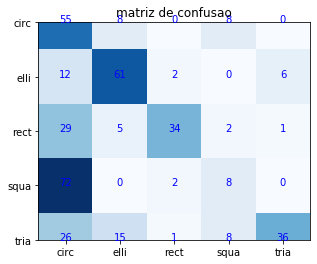

In [22]:
# class Figura(object):

from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing


#     def __init__(self, x):
#         x,y = prepara_dados()
#         clf = treina_rede(x,y)
#         self.categoria = clf.predict(x)


def prepara_dados():
    data = pd.read_csv('features.csv')
    y = list(data.columns)
    for i in range(len(y)):
        y[i] = y[i][0:4]
    x = (data.iloc[0::]).T

    X_ = []
    #print(list(x.iloc[0]))
    #print(x.iloc[1])
    #print(x.shape[1])
    for i in range(x.shape[0]-1):
        #print(i)
        #print(list(x.iloc[i]))
        #print(len(x.iloc[i]))
        X_.append(list(x.iloc[i]))
    #print(y)
    
#     teste = pd.DataFrame(X_)
#     teste.to_csv('vendox.csv')

    return(X_,y)



def treina_rede(x,y):
    import random
    from sklearn import ensemble
    from sklearn.neural_network import MLPClassifier

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    
    #x = imagens
    sample_index=random.sample(range(len(x)),int(len(x)/5)) #20-80
    valid_index=[i for i in range(len(x)) if i not in sample_index]

    sample_images=[x[i] for i in sample_index]
    valid_images=[x[i] for i in valid_index]

    #Sample and validation targets
    sample_target=[y[i] for i in sample_index]
    valid_target=[y[i] for i in valid_index]



    #USANDO REDE NEURAL
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2048,100,10,5), random_state=1, max_iter=50000, 
                        learning_rate_init=0.001)
    clf.fit(sample_images, sample_target)
    print('score: ',clf.score(valid_images, valid_target))  

    return clf,le

def faz_knn(x,y):
    import random
    from sklearn import ensemble
    from sklearn.neighbors import KNeighborsClassifier

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    
   # print(y)
    #x = imagens
    sample_index=random.sample(range(len(x)),int(len(x)/5)) #20-80
    valid_index=[i for i in range(len(x)) if i not in sample_index]

    sample_images=[x[i] for i in sample_index]
    valid_images=[x[i] for i in valid_index]
    
    #Sample and validation targets
    sample_target=[y[i] for i in sample_index]
    valid_target=[y[i] for i in valid_index]
    
    knn = KNeighborsClassifier()
    knn.fit(sample_images, sample_target)
    print('score: ',knn.score(valid_images, valid_target))      
    
    
    ## MATRIZ DE CONFUSAO
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    rotulos_previstos = le.inverse_transform(knn.predict(valid_images))
    matriz = confusion_matrix(le.inverse_transform(valid_target), rotulos_previstos)
    
    
    labels = [0,1,2,3,4]
    
    marcador_escalas = range(len(labels))
    
    plt.imshow(matriz, cmap = plt.cm.Blues, interpolation = 'nearest')
    plt.title('matriz de confusao')
    
    plt.yticks(marcador_escalas, le.inverse_transform(labels))
    plt.xticks(marcador_escalas, le.inverse_transform(labels))
    
    for linha in range(matriz.shape[0]):
        for coluna in range(matriz.shape[1]):
            plt.text(coluna, linha, format(matriz[linha,coluna]), horizontalalignment = 'center', color = 'blue')
    
    plt.show()
    return knn,le

x,y = prepara_dados()
#print(len(x[1]))

#REDE NEURAL
#clf, le = treina_rede(x,y)

# KNN CLASSIFIER 
knn, le = faz_knn(x,y)

## From the confusion matrix we can see that the worst preddictions are squares and circles 
we should use  matplotlib 3.1.0 to avoid first and last row to be cut

/home/leticia/miniconda3/envs/ambi/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leticia/miniconda3/envs/ambi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


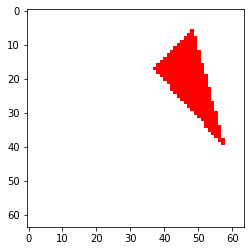

categoria: ['tria']


In [65]:
import numpy as np
import cv2

# opcoes de png: rectangle, circle, triangle, square, ellipse
path = 'imagens/teste_extra/triangle.png'
x = extract_features(path)
x=x.reshape(1, -1)
categoria = clf.predict(x)
fig = show_img(path)
print('categoria:', le.inverse_transform(categoria))




#show_img()